## Projekt dotyczący predykcji cen mieszkań w Bostonie

Projekt oparty jest na danych dostępnych na stronie <a href="https://www.kaggle.com">Kaggle</a>. 
Dane na stronie są aktualizowane o nowe rekordy, dlatego pliki z których korzystałem umieszczam <a href="https://www.kaggle.com/airbnb/boston">tutaj</a>. Zawierają one informacje dotyczące mieszkań w Bostonie.
Na podstawie tych informacji został stworzony algortym przewidujący ceny mieszkań w Bostonie.

Pierwszym krokiem jest zaimportowanie potrzebnych bibliotek na potrzeby tego projektu.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost
import shap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
%matplotlib inline

Kolejnym krokiem jest zaimportowanie danych.

In [2]:
boston_listings = pd.read_csv("./listings.csv")
boston_calendar = pd.read_csv("./calendar.csv")
boston_reviews = pd.read_csv("./reviews.csv")

Jednym z ważniejszych elementów jakie należy zrobić jest analiza danych w celu ich zrozumienia.

In [3]:
boston_calendar.head(3)

,listing_id,date,available,price
0,12147973,2017-09-05,f,NaN
1,12147973,2017-09-04,f,NaN
2,12147973,2017-09-03,f,NaN


In [4]:
boston_calendar.sort_values(by="date", inplace=True)
min_date = boston_calendar["date"]
max_date = boston_calendar["date"]

In [5]:
print("Start data: " + str(min_date.iloc[0]))

Start data: 2016-09-06


In [6]:
print("Stop data: " + str(max_date.iloc[-1]))

Stop data: 2017-09-05


In [7]:
boston_reviews.head(3)

,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...


In [8]:
boston = boston_listings.copy()

In [9]:
len(boston)

3585

In [10]:
boston.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47


In [11]:
boston.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

Przygotowanie zmiennej celu do dalszej analizy.

In [12]:
boston["price"] = boston["price"].apply(lambda change_describe_price: change_describe_price.replace("$",""))
boston["price"] = boston["price"].apply(lambda change_describe_price: change_describe_price.replace(",",""))

boston["price"] = boston["price"].astype("float")
boston["price"].describe()

count    3585.000000
mean      173.925802
std       148.331321
min        10.000000
25%        85.000000
50%       150.000000
75%       220.000000
max      4000.000000
Name: price, dtype: float64

In [13]:
boston["price"].head()

0    250.0
1     65.0
2     65.0
3     75.0
4     79.0
Name: price, dtype: float64

In [14]:
boston.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                3585 non-null   int64  
 1   listing_url                       3585 non-null   object 
 2   scrape_id                         3585 non-null   int64  
 3   last_scraped                      3585 non-null   object 
 4   name                              3585 non-null   object 
 5   summary                           3442 non-null   object 
 6   space                             2528 non-null   object 
 7   description                       3585 non-null   object 
 8   experiences_offered               3585 non-null   object 
 9   neighborhood_overview             2170 non-null   object 
 10  notes                             1610 non-null   object 
 11  transit                           2295 non-null   object 
 12  access

In [15]:
list(boston.describe())

['id',
 'scrape_id',
 'host_id',
 'host_listings_count',
 'host_total_listings_count',
 'neighbourhood_group_cleansed',
 'latitude',
 'longitude',
 'accommodates',
 'bathrooms',
 'bedrooms',
 'beds',
 'square_feet',
 'price',
 'guests_included',
 'minimum_nights',
 'maximum_nights',
 'has_availability',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'number_of_reviews',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'license',
 'jurisdiction_names',
 'calculated_host_listings_count',
 'reviews_per_month']

In [16]:
boston.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,3585.0,8.440875e+06,4.500787e+06,3.353000e+03,4.679319e+06,8.577620e+06,1.278953e+07,1.493346e+07
scrape_id,3585.0,2.016091e+13,8.516813e-01,2.016091e+13,2.016091e+13,2.016091e+13,2.016091e+13,2.016091e+13
host_id,3585.0,2.492311e+07,2.292781e+07,4.240000e+03,6.103425e+06,1.928100e+07,3.622147e+07,9.385411e+07
host_listings_count,3585.0,5.890237e+01,1.711197e+02,0.000000e+00,1.000000e+00,2.000000e+00,7.000000e+00,7.490000e+02
host_total_listings_count,3585.0,5.890237e+01,1.711197e+02,0.000000e+00,1.000000e+00,2.000000e+00,7.000000e+00,7.490000e+02
neighbourhood_group_cleansed,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
latitude,3585.0,4.234003e+01,2.440255e-02,4.223594e+01,4.232999e+01,4.234520e+01,4.235469e+01,4.238998e+01
longitude,3585.0,-7.108482e+01,3.156464e-02,-7.117179e+01,-7.110508e+01,-7.107843e+01,-7.106215e+01,-7.100010e+01
accommodates,3585.0,3.041283e+00,1.778929e+00,1.000000e+00,2.000000e+00,2.000000e+00,4.000000e+00,1.600000e+01
bathrooms,3571.0,1.221647e+00,5.014871e-01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,6.000000e+00


In [17]:
print(len(boston))
boston.describe(include=["object"])

3585


,listing_url,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,...,extra_people,calendar_updated,calendar_last_scraped,first_review,last_review,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
count,3585,3585,3585,3442,2528,3585,3585,2170,1610,2295,...,3585,3585,3585,2829,2829,3585,3585,3585,3585,3585
unique,3585,1,3504,3113,2268,3423,1,1728,1269,1859,...,51,38,1,975,404,1,2,4,2,2
top,https://www.airbnb.com/rooms/629814,2016-09-07,Lux 2BR by Fenway w/WiFi,"The unit is stylishly designed for comfort, va...",The studio's kitchenette comes equipped with a...,Studio offers the luxury of home furnishings w...,none,Conveniently bordering the neighborhoods of th...,Although we do not allow pets in our apartment...,"These newly constructed, luxury apartments epi...",...,$0.00,today,2016-09-06,2016-04-05,2016-09-05,f,f,strict,f,f
freq,1,3585,8,21,17,7,3585,21,44,26,...,2211,833,3585,23,118,3585,2991,1582,3518,3348


In [18]:
first_condition = boston.describe(include=["object"]).transpose()["unique"] < 10
second_condition = boston.describe(include=["object"]).transpose()["unique"] > 1
important_parameters_x = boston.describe(include=["object"]).transpose()["unique"][first_condition & second_condition]
important_parameters_x

host_response_time                  4
host_is_superhost                   2
host_has_profile_pic                2
host_identity_verified              2
market                              4
is_location_exact                   2
room_type                           3
bed_type                            5
instant_bookable                    2
cancellation_policy                 4
require_guest_profile_picture       2
require_guest_phone_verification    2
Name: unique, dtype: object

Dobieranie zmiennych do modelu, które mają największy wpływ na ostateczny rezultat i autentyczność wyników.

In [19]:
model = smf.ols("price ~ bathrooms + bedrooms + beds + room_type", data=boston).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.279
Model:                            OLS   Adj. R-squared:                  0.278
Method:                 Least Squares   F-statistic:                     274.4
Date:                Sun, 21 Feb 2021   Prob (F-statistic):          1.10e-248
Time:                        12:43:41   Log-Likelihood:                -22258.
No. Observations:                3557   AIC:                         4.453e+04
Df Residuals:                    3551   BIC:                         4.456e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [20]:
bostotn_important = boston[["bathrooms", "bedrooms", "beds", "room_type", "price"]]
print(len(bostotn_important))

3585


In [21]:
bostotn_important.head()

,bathrooms,bedrooms,beds,room_type,price
0,1.5,2.0,3.0,Entire home/apt,250.0
1,1.0,1.0,1.0,Private room,65.0
2,1.0,1.0,1.0,Private room,65.0
3,1.0,1.0,2.0,Private room,75.0
4,1.5,1.0,2.0,Private room,79.0


In [22]:
bostotn_important.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3585 entries, 0 to 3584
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   bathrooms  3571 non-null   float64
 1   bedrooms   3575 non-null   float64
 2   beds       3576 non-null   float64
 3   room_type  3585 non-null   object 
 4   price      3585 non-null   float64
dtypes: float64(4), object(1)
memory usage: 140.2+ KB


In [23]:
print(len(bostotn_important))
bostotn_important = bostotn_important.dropna()
print(len(bostotn_important))

3585
3557


In [24]:
absence_bathrooms = bostotn_important["bathrooms"] == 0
absence_bedrooms = bostotn_important["bedrooms"] == 0
absence_beds = bostotn_important["beds"] == 0

print(len(bostotn_important[absence_bathrooms]))
print(len(bostotn_important[absence_bedrooms]))
print(len(bostotn_important[absence_beds]))

print("All rows: " + str(len(bostotn_important)))

13
287
4
All rows: 3557


In [25]:
len(bostotn_important)

3557

Standaryzacja danych.

In [26]:
bostotn_important["room_type"] = bostotn_important["room_type"].apply(lambda change_describe: change_describe.replace("Entire home/apt","0"))
bostotn_important["room_type"] = bostotn_important["room_type"].apply(lambda change_describe: change_describe.replace("Private room","1"))
bostotn_important["room_type"] = bostotn_important["room_type"].apply(lambda change_describe: change_describe.replace("Shared room","2"))

In [27]:
bostotn_important["room_type"] = bostotn_important["room_type"].astype("float")

In [28]:
bostotn_important.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3557 entries, 0 to 3584
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   bathrooms  3557 non-null   float64
 1   bedrooms   3557 non-null   float64
 2   beds       3557 non-null   float64
 3   room_type  3557 non-null   float64
 4   price      3557 non-null   float64
dtypes: float64(5)
memory usage: 166.7 KB


In [29]:
print(bostotn_important["beds"].idxmax())
bostotn_important.loc[bostotn_important["beds"].idxmax()]

2294


bathrooms      1.0
bedrooms       1.0
beds          16.0
room_type      0.0
price        229.0
Name: 2294, dtype: float64

In [30]:
bostotn_important = bostotn_important.drop(index=bostotn_important["beds"].idxmax())

In [31]:
bostotn_important["beds"].max()

9.0

In [32]:
print(bostotn_important["price"].idxmax())
bostotn_important.loc[bostotn_important["price"].idxmax()]
print(bostotn_important["price"].idxmax())
bostotn_important.loc[bostotn_important["price"].idxmax()]

2285
2285


bathrooms       1.0
bedrooms        1.0
beds            2.0
room_type       0.0
price        4000.0
Name: 2285, dtype: float64

In [33]:
bostotn_important = bostotn_important.drop(index=bostotn_important["price"].idxmax())
bostotn_important = bostotn_important.drop(index=bostotn_important["price"].idxmax())

In [34]:
bostotn_important.head()

,bathrooms,bedrooms,beds,room_type,price
0,1.5,2.0,3.0,0.0,250.0
1,1.0,1.0,1.0,1.0,65.0
2,1.0,1.0,1.0,1.0,65.0
3,1.0,1.0,2.0,1.0,75.0
4,1.5,1.0,2.0,1.0,79.0


In [35]:
scaler = StandardScaler()

In [36]:
X = bostotn_important.drop(labels=["price"],axis=1)
X_scl = scaler.fit_transform(X)


In [37]:
print(len(X_scl))
X_scl

3554


array([[ 0.55269045,  0.9845902 ,  1.41404146, -0.79665698],
       [-0.44288069, -0.34037518, -0.61728568,  1.06238366],
       [-0.44288069, -0.34037518, -0.61728568,  1.06238366],
       ...,
       [-0.44288069, -0.34037518, -0.61728568, -0.79665698],
       [-0.44288069, -0.34037518, -0.61728568,  1.06238366],
       [-0.44288069, -0.34037518, -0.61728568,  1.06238366]])

In [38]:
y = bostotn_important["price"].to_numpy(dtype = "float64")
print(len(y))
y

3554


array([250.,  65.,  65., ..., 198.,  65.,  65.])

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X_scl, y, test_size= 0.2, random_state=0)

In [40]:
print("X_train shape: {}".format(X_train.shape))
print("X_test shape: {}".format(X_test.shape))
print("y_train shape: {}".format(y_train.shape))
print("y_train shape: {}".format(y_test.shape))

X_train shape: (2843, 4)
X_test shape: (711, 4)
y_train shape: (2843,)
y_train shape: (711,)


Wizualizacja kilku istotnych danych.

In [41]:
boston["room_type"].value_counts()

Entire home/apt    2127
Private room       1378
Shared room          80
Name: room_type, dtype: int64

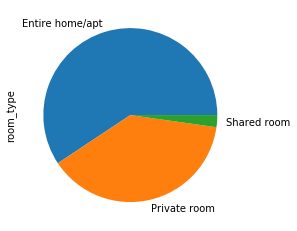

In [42]:
boston["room_type"].value_counts().plot(kind="pie")

In [43]:
boston["property_type"].value_counts()

Apartment          2612
House               562
Condominium         231
Townhouse            54
Bed & Breakfast      41
Loft                 39
Other                17
Boat                 12
Villa                 6
Entire Floor          4
Dorm                  2
Guesthouse            1
Camper/RV             1
Name: property_type, dtype: int64

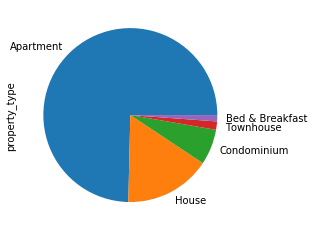

In [44]:
boston["property_type"].value_counts()[boston["property_type"].value_counts() > 40].plot(kind="pie")

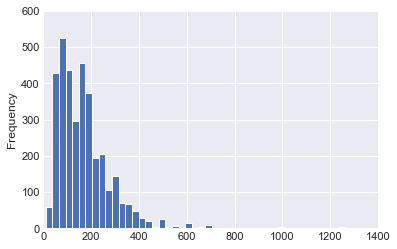

In [84]:
boston["price"].plot(kind="hist",bins=50, xlim = [0,1400], ylim=[0,600])
plt.style.use("seaborn-darkgrid")


In [46]:
bostotn_important["price"].max()

1400.0

In [47]:
list_columns = list(bostotn_important.columns)
list_columns

['bathrooms', 'bedrooms', 'beds', 'room_type', 'price']

In [48]:
corr = bostotn_important.corr()
corr

,bathrooms,bedrooms,beds,room_type,price
bathrooms,1.000000,0.430489,0.359377,-0.075255,0.288585
bedrooms,0.430489,1.000000,0.733106,-0.271162,0.452700
beds,0.359377,0.733106,1.000000,-0.358414,0.444346
room_type,-0.075255,-0.271162,-0.358414,1.000000,-0.484897
price,0.288585,0.452700,0.444346,-0.484897,1.000000


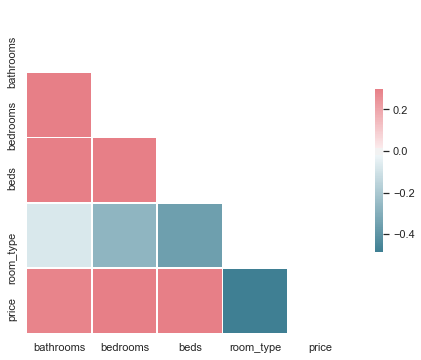

In [49]:
sns.set(style="white")
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(8, 6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [50]:
bostotn_important.corr()['price'].sort_values(ascending=False)

price        1.000000
bedrooms     0.452700
beds         0.444346
bathrooms    0.288585
room_type   -0.484897
Name: price, dtype: float64

Sprawdzenie korelacji pomiędzy wybranymi zmiennymi.

The `size` parameter has been renamed to `height`; please update your code.


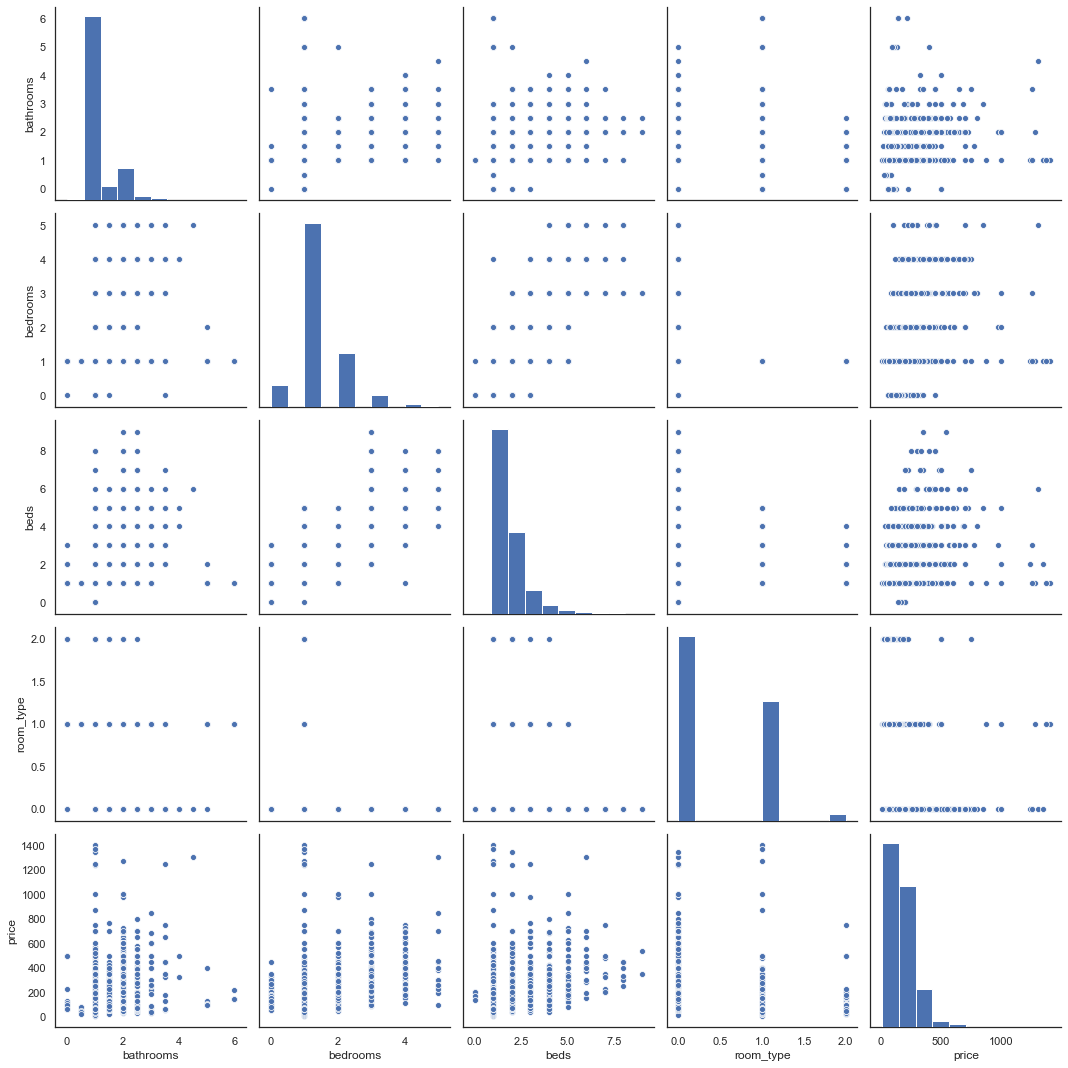

In [51]:
sns.pairplot(bostotn_important,size=3)
plt.tight_layout()
plt.style.use("seaborn-darkgrid")

plt.show()

Tworzenie obiektu regresji liniowej.

In [52]:
regressor = LinearRegression()

In [53]:
X_train

array([[-0.44288069, -0.34037518,  2.42970503, -0.79665698],
       [ 1.54826158, -0.34037518, -0.61728568,  1.06238366],
       [-0.44288069, -1.66534056, -0.61728568, -0.79665698],
       ...,
       [-0.44288069, -0.34037518, -0.61728568, -0.79665698],
       [-0.44288069, -1.66534056, -0.61728568, -0.79665698],
       [-0.44288069, -0.34037518, -0.61728568,  1.06238366]])

In [54]:
y_train

array([130.,  80., 199., ...,  65., 130.,  45.])

In [55]:
print(len(X_train))
print(len(X_test))

2843
711


In [56]:
regressor.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [57]:
y_pred = regressor.predict(X_test)
y_pred[:15]

array([112.99096422,  99.01265494, 186.89783666,  99.01265494,
       294.76303201,  99.01265494, 310.54249893, 246.91901015,
       186.89783666,  11.12747322, 112.99096422, 186.89783666,
       248.72016779, 214.85445522, 262.69847708])

[]

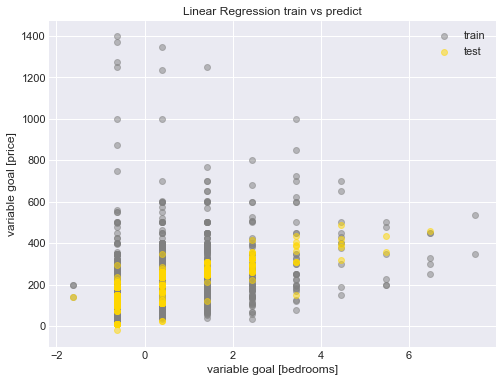

In [58]:
plt.figure(figsize=(8, 6))
plt.title("Linear Regression train vs predict")
plt.xlabel("variable goal [bedrooms]")
plt.ylabel("variable goal [price]")
plt.scatter(X_train[:,2], y_train, label="train", color="gray", alpha=0.5)
plt.scatter(X_test[:,2], y_pred, label="test", color="gold", alpha=0.5)
plt.style.use("seaborn-darkgrid")
plt.legend()
plt.plot()

[]

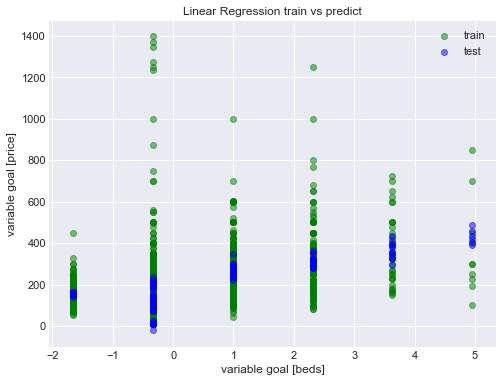

In [59]:
plt.figure(figsize=(8, 6))
plt.title("Linear Regression train vs predict")
plt.xlabel("variable goal [beds]")
plt.ylabel("variable goal [price]")
plt.scatter(X_train[:,1], y_train, label="train", color="green", alpha=0.5)
plt.scatter(X_test[:,1], y_pred, label="test", color="blue", alpha=0.5)
plt.style.use("seaborn-darkgrid")
plt.legend()
plt.plot()

In [60]:
regressor.coef_

array([ 14.04049277,  26.91909606,  11.98935554, -47.27448124])

In [61]:
regressor.intercept_

172.01800414882058

# lasso

In [62]:
boston = bostotn_important

In [63]:
boston.head()

,bathrooms,bedrooms,beds,room_type,price
0,1.5,2.0,3.0,0.0,250.0
1,1.0,1.0,1.0,1.0,65.0
2,1.0,1.0,1.0,1.0,65.0
3,1.0,1.0,2.0,1.0,75.0
4,1.5,1.0,2.0,1.0,79.0


In [64]:
features = boston[["bathrooms", "bedrooms", "beds", "room_type"]]

In [65]:
features.head()

,bathrooms,bedrooms,beds,room_type
0,1.5,2.0,3.0,0.0
1,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0
3,1.0,1.0,2.0,1.0
4,1.5,1.0,2.0,1.0


In [66]:
target = boston["price"]

In [67]:
target.head()
target = target.to_numpy(dtype = "float64")

In [68]:
feautures_standardized = scaler.fit_transform(features)

In [69]:
feautures_standardized

array([[ 0.55269045,  0.9845902 ,  1.41404146, -0.79665698],
       [-0.44288069, -0.34037518, -0.61728568,  1.06238366],
       [-0.44288069, -0.34037518, -0.61728568,  1.06238366],
       ...,
       [-0.44288069, -0.34037518, -0.61728568, -0.79665698],
       [-0.44288069, -0.34037518, -0.61728568,  1.06238366],
       [-0.44288069, -0.34037518, -0.61728568,  1.06238366]])

In [70]:
target

array([250.,  65.,  65., ..., 198.,  65.,  65.])

In [71]:
X_train, X_test, y_train, y_test = train_test_split(feautures_standardized, target, test_size= 0.2, random_state=0)

Tworzenie obiektu regresji lasso.

In [72]:
reg_lasso = Lasso(alpha=0.1)

In [73]:
model = reg_lasso.fit(X_train,y_train)

In [74]:
y_predict = model.predict(X_test)

[]

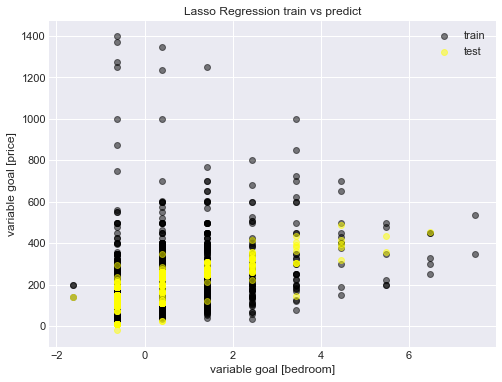

In [75]:
plt.figure(figsize=(8, 6))
plt.title("Lasso Regression train vs predict")
plt.xlabel("variable goal [bedroom]")
plt.ylabel("variable goal [price]")
plt.scatter(X_train[:,2], y_train, label="train", color="black", alpha=0.5)
plt.scatter(X_test[:,2], y_predict, label="test", color="yellow", alpha=0.5)
plt.style.use("seaborn-darkgrid")
plt.legend()
plt.plot()

[]

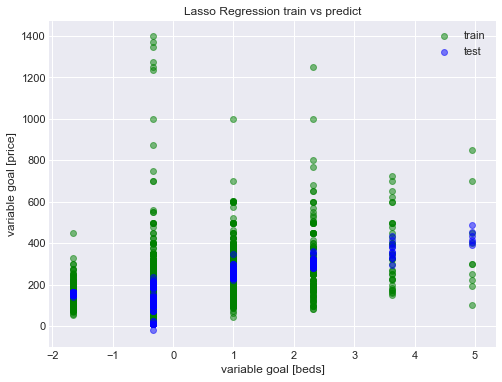

In [76]:
plt.figure(figsize=(8, 6))
plt.title("Lasso Regression train vs predict")
plt.xlabel("variable goal [beds]")
plt.ylabel("variable goal [price]")
plt.scatter(X_train[:,1], y_train, label="train", color="green", alpha=0.5)
plt.scatter(X_test[:,1], y_predict, label="test", color="blue", alpha=0.5)
plt.style.use("seaborn-darkgrid")
plt.legend()
plt.plot()

In [77]:
coef = pd.DataFrame(data=[regressor.coef_,model.coef_]).T

In [78]:
coef.columns = ["Linear","Lasso"]

In [79]:
coef

,Linear,Lasso
0,14.040493,13.966781
1,26.919096,26.885358
2,11.989356,11.964863
3,-47.274481,-47.195472


Tworzenie obiektu xgboost.

In [80]:
model = xgboost.XGBRegressor(n_estimators=10)
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=10, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [81]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

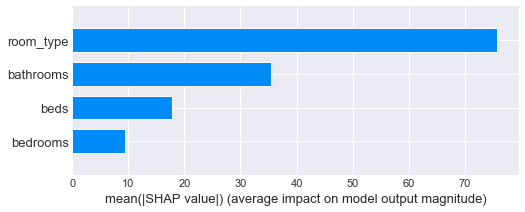

In [82]:
shap.summary_plot(shap_values, X, plot_type="bar")

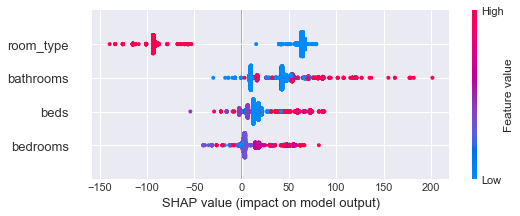

In [83]:
shap.summary_plot(shap_values, features=X, feature_names=X.columns)